# Import modules and methods

In [2]:
# Likely you will need to install these
# pip install fair-esm
# You may need to uninstall numpy and sci-kit learn and then install numpy first then sci-kit learn, somehow the order matters
# pip install torch
# pip install rdkit
# pip install umap-learn
# With umap, there may be odd dependencies on the Numba version, affected by Numpy version.

In [3]:
from Methods_DimRed import * 
# Several items are in a separate accompanying Dim_Meth.py file, 
# including the encoders and amino acid descriptors (SMILES and properties)

import os, math, pkg_resources
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import manifold
import umap.umap_ as umap
# UMAP results can be slightly affected by version number, version 0.5.3 was used for these results
print(f'UMAP version is {pkg_resources.get_distribution("umap-learn").version}')

UMAP version is 0.5.3


In [4]:
# For use if you modify the Dim_Meth.py and don't want to restart the kernel
# from importlib import reload
# import Dim_Meth
# reload(Dim_Meth)
# from Dim_Meth import *

# Inputs, outputs, parameters

In [5]:
# Choose dimensionality techniques
Available_Dim_red = {'PCA': True, 'MDS': False, 'UMAP': True}
# Choose representations used for encoding
Available_Representations = {'OneHot': True, 'PhysProperties': True, 'ESM2' : True, 'Fingerprint': True,  'NGrams': True}

# Inputs
file = 'All Data Randomized C-L.csv'
df = pd.read_csv(file)
seq_list = [seq[0:12] for seq in df['Peptide']] # Isolates the X12 variable region from all peptides. This is specific to AS-MS
print(f'{len(seq_list)} peptides! Note that >1000 of peptides usually work well, 100 does not.', flush=True) 
print(f'If using UMAP, n_neighbors is recommended to be {math.floor(len(seq_list)*0.05)} with n_bors = {math.ceil(math.log2(len(seq_list)*0.05))}')

# Outputs
# Outputs are currently saved in the current working directory using the Savetitle as a prefix
Savetitle = f'{file[:-4]}'
ESM_OUTPUT = f'{Savetitle} ESM2 Encoding Output.csv' # ESM2 encoding takes time, so the encoded file is kept

4104 peptides! Note that >1000 of peptides usually work well, 100 does not.
If using UMAP, n_neighbors is recommended to be 205 with n_bors = 8


In [7]:
# Parameters
NBITS = 256 # For Fingerprint encoding, 256 was optimal see SI
RADIUS = 3  # For Fingerprint encoding, ECFP_6
SEED = 108  # Random state, should be set to a defined number to achieve reproducible results for PCA, MDS, and/or UMAP

n_bors = [8] # As a list, you can iterate over n_bors by modifying the code. 
# This can be desired to determine if UMAP embeddings are stable
# More modifications will be required than just adding to this list

min_dict = {'OneHot': 0.4, 'Fingerprint': 0.1, 'PhysProperties': 0.1, 'NGrams': 0.1, 'ESM2': 0.1} # default is 0.1
# min_dist of 0.4 was used to partially disperse the tight clusters of PCA One hot, but the default of 0.1 works well

# Binary encoding (e.g., OneHot, Fingerprint, NGrams) should use Tanimoto distance metric, though minimal changes are seen in the results
# Property-based and ESM2 encoding produce a continuous descriptor, thus it should use a Euclidean distance metric.
# See D. Bajusz, A. Rácz, and K Héberger. J Cheminform 7, 20 (2015).
metric_dict = {'OneHot': 'rogerstanimoto', 'Fingerprint': 'rogerstanimoto', 'PhysProperties': 'euclidean', 'NGrams': 'rogerstanimoto', 'ESM2': 'euclidean'}

In [4]:
# Construct lists of the dimensionality reduction and representation methods used
dim_red_list = []
for key,value in Available_Dim_red.items():
    if bool(value): dim_red_list.append(key)
print(dim_red_list)

seq_rep_list = []
for key,value in Available_Representations.items():
    if bool(value): seq_rep_list.append(key)
print(seq_rep_list)

['PCA', 'UMAP']
['OneHot', 'PhysProperties', 'ESM2', 'Fingerprint', 'NGrams']


# Encoding

In [7]:
print(f'Encoding Data')
seq_rep = {}
if 'OneHot' in seq_rep_list:
    print('Encoding OneHot',flush=True)
    seq_rep['OneHot'] = [one_hot(seq) for seq in seq_list]
    
if 'Fingerprint' in seq_rep_list:
    print('Encoding Fingerprint',flush=True)
    fp = Fingerprint_Generation(Std_All_AA_Smiles.keys(),RADIUS,NBITS)
    seq_rep['Fingerprint'] = [fingerprint(seq,NBITS,fp) for seq in seq_list]
    
if 'PhysProperties' in seq_rep_list:
    print('Encoding PhysProperties',flush=True)
    seq_rep['PhysProperties'] = [ext_prop_enc(seq) for seq in seq_list]
    
if 'NGrams' in seq_rep_list:
    NGRAM_MAX = minlengthfinder(seq_list)
    print(f'NGRAM_MAX is {NGRAM_MAX}, now calculating n_mers (the index of the N-grams vector)',flush=True)
    n_mers = [list(cal_n_mers(seq_list, n)) for n in range(1, NGRAM_MAX+1)] # n-mers are calculated here, if additional peptides are added, the same n-mers should be used
    print('Encoding N-grams using the precalculated n_mers',flush=True)
    seq_rep['NGrams'] = enc_ngrams(seq_list,n_mers)
    
if 'ESM2' in seq_rep_list:
    print('Encoding ESM2',flush=True)
    seq_rep['ESM2'] = ESM2(seq_list,ESM_OUTPUT)
print('Done')

Encoding Data
Encoding OneHot
Encoding Fingerprint
Encoding PhysProperties
NGRAM_MAX is 12, now calculating n_mers (the index of the N-grams vector)
Encoding N-grams using the precalculated n_mers
Encoding ESM2


100%|██████████████████████████████████████████████████████████████████████████████| 129/129.0 [34:42<00:00, 16.14s/it]


Done


# Dimensionality reduction

In [8]:
data = {}

In [9]:
if 'UMAP' in dim_red_list:
    print('UMAP running',flush=True)
    umap_all = {}                        # Dictionaries will hold the data, format of umap_all[min_dist][representation][n_neighbors]
    umap_fn_dict = {}
    umap_embeddding_dict = {}
    
    for rep in seq_rep:              # iterate over representation
        min_num = min_dict[rep]
        print(f'min_num is {min_num} for {rep}')
        ref_feature = seq_rep[rep]

        reducer_scaled_dict = {}
        embedding_scaled_dict = {}

        for n_neighbors in n_bors:   # iterate over n_neighbors if n_bors is constructed with multiple numbers
            print(f'n_neighbors is {n_neighbors}',flush=True)
            reducer_scaled_dict[2**n_neighbors] = umap.UMAP(
                n_components=2, n_neighbors=2**n_neighbors, min_dist=min_dict[rep], random_state=SEED, metric=metric_dict[rep])
            embedding_scaled_dict[2**n_neighbors] = reducer_scaled_dict[2**n_neighbors].fit_transform(ref_feature)

        umap_fn_dict[rep] = reducer_scaled_dict            
        umap_embeddding_dict[rep] = embedding_scaled_dict
        umap_all[min_num] = umap_embeddding_dict
    data['UMAP'] = umap_all

UMAP running
min_num is 0.4 for OneHot
n_neighbors is 8


C:\Joseph\Anaconda\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


min_num is 0.1 for Fingerprint
n_neighbors is 8


C:\Joseph\Anaconda\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


min_num is 0.1 for PhysProperties
n_neighbors is 8
min_num is 0.1 for NGrams
n_neighbors is 8


C:\Joseph\Anaconda\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


min_num is 0.1 for ESM2
n_neighbors is 8


In [10]:
if 'PCA' in dim_red_list:
    print('PCA running',flush=True)
    pca_fn_dict = {}
    pca_embeddding_dict = {}
    for rep in seq_rep:
        ref_feature = seq_rep[rep]
        reducer_scaled_dict = {}
        embedding_scaled_dict = {}

        pca = decomposition.PCA(n_components=2, random_state=SEED)
        embedding = pca.fit_transform(ref_feature)
        pca_fn_dict[rep] = pca
        pca_embeddding_dict[rep] = embedding
    data['PCA'] = pca_embeddding_dict

PCA running


In [11]:
if 'MDS' in dim_red_list:
    print('MDS running',flush=True)
    mds_fn_dict = {}
    mds_embeddding_dict = {}
    for rep in seq_rep:
        print(rep)
        ref_feature = seq_rep[rep]
        reducer_scaled_dict = {}
        embedding_scaled_dict = {}

        mds = manifold.MDS(n_components=2, random_state=SEED, n_jobs=-1)
        embedding = mds.fit_transform(ref_feature)
        mds_fn_dict[rep] = mds
        mds_embeddding_dict[rep] = embedding
    data['MDS'] = mds_embeddding_dict

# Save data

In [12]:
df_final = pd.DataFrame()
df_final['Peptide'] = seq_list

for j,enc in enumerate(seq_rep):
    for k,red in enumerate(dim_red_list):
        if red == 'UMAP':
            C1 = data[red][min_dict[enc]][enc][2**n_bors[0]][:,0]
            C2 = data[red][min_dict[enc]][enc][2**n_bors[0]][:,1]
        else:
            C1 = data[red][enc][:,0]
            C2 = data[red][enc][:,1]    
        df_final[f'{red} {enc} C1'] = C1
        df_final[f'{red} {enc} C2'] = C2
df_final.to_csv(f'{Savetitle} DimRed Embeddings.csv', index=None)

# Plotting

OneHot PCA
PhysProperties PCA
ESM2 PCA
Fingerprint PCA
NGrams PCA
OneHot UMAP
PhysProperties UMAP
ESM2 UMAP
Fingerprint UMAP
NGrams UMAP


<function matplotlib.pyplot.show(close=None, block=None)>

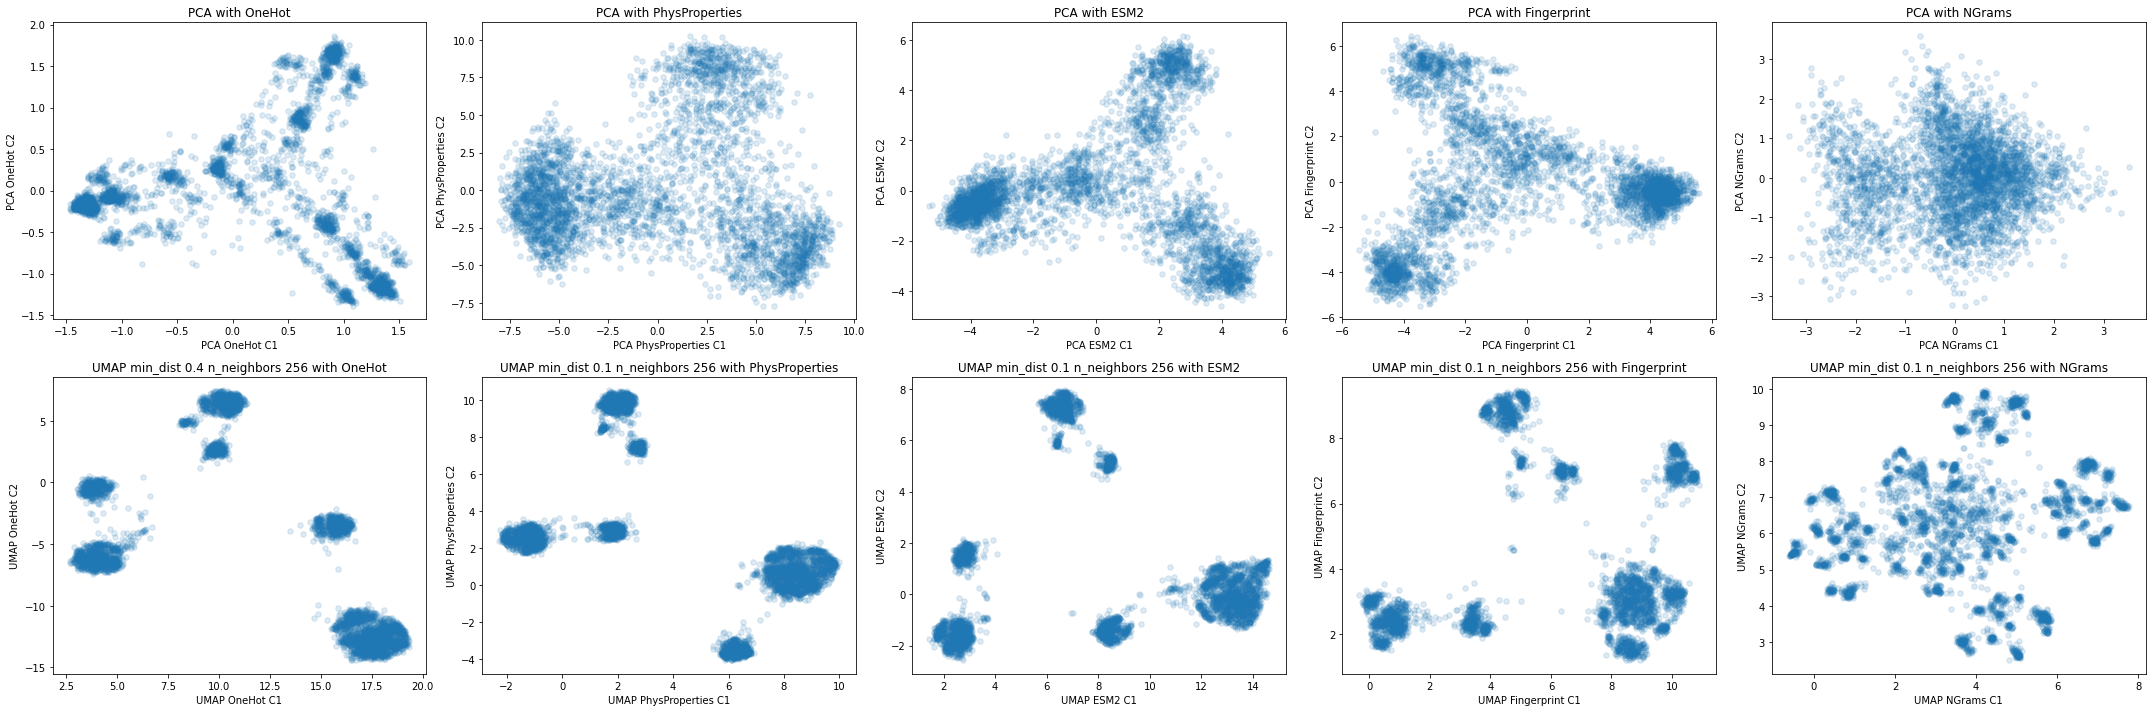

In [50]:
fig, axes = plt.subplots(len(dim_red_list),len(seq_rep_list),figsize = (6*len(seq_rep_list),5*len(dim_red_list)))
reps_plotting = lister(dim_red_list,seq_rep_list)

for ax, (red,enc) in zip(fig.axes,reps_plotting):
    print(enc,red)
    if red == 'UMAP':
        C1 = data[red][min_dict[enc]][enc][2**n_bors[0]][:,0]
        C2 = data[red][min_dict[enc]][enc][2**n_bors[0]][:,1]
        ax.set_title(f'{red} min_dist {min_dict[enc]} n_neighbors {2**n_bors[0]} with {enc}')

    else:
        C1 = data[red][enc][:,0]
        C2 = data[red][enc][:,1]    
        ax.set_title(f'{red} with {enc}')

    plot = ax.scatter(C1,C2,s=30,marker='o',alpha=0.15,c='tab:blue') 

    ax.set_xlabel(f'{red} {enc} C1')
    ax.set_ylabel(f'{red} {enc} C2')

plt.tight_layout()
plt.savefig(f'{Savetitle} DimRed Embeddings.png',dpi=300)
plt.show

# Add randomly sample peptides from library, if desired

## Inputs and Parameters

In [14]:
lib_file = 'All Lib QC Randomized.csv'
ESM_OUTPUT2 = f'{ESM_OUTPUT[:-4]} Library.csv'
df_lib = pd.read_csv(lib_file)
lib_seq_list = [seq[0:12] for seq in df_lib['Peptide']] # Isolates the X12 variable region from all peptides. This is specific to AS-MS

# Choose dimensionality techniques
Available_Dim_red_Add_Libs = {'PCA': True, 'UMAP': True} # MDS is unavailable to add data after the space is learned

In [15]:
lib_dim_red_list = []
for key,value in Available_Dim_red_Add_Libs.items():
    if bool(value): lib_dim_red_list.append(key)
print(lib_dim_red_list)

['PCA', 'UMAP']


## Encoding

In [16]:
print(f'Encoding Data from {lib_file}')
lib_seq_rep = {}
if 'OneHot' in seq_rep_list:
    print('Encoding OneHot',flush=True)
    lib_seq_rep['OneHot'] = [one_hot(seq) for seq in lib_seq_list]
    
if 'Fingerprint' in seq_rep_list:
    print('Encoding Fingerprint',flush=True)
    lib_seq_rep['Fingerprint'] = [fingerprint(seq,NBITS,fp) for seq in lib_seq_list]
    
if 'PhysProperties' in seq_rep_list:
    print('Encoding PhysProperties',flush=True)
    lib_seq_rep['PhysProperties'] = [ext_prop_enc(seq) for seq in lib_seq_list]
    
if 'NGrams' in seq_rep_list:
    print('Encoding NGrams',flush=True) # Note these peptides must have the same NGRAM_MAX
    LIB_NGRAM_MAX = minlengthfinder(lib_seq_list)
    if LIB_NGRAM_MAX == NGRAM_MAX:
        lib_seq_rep['NGrams'] = enc_ngrams(lib_seq_list,n_mers) # This uses the n_mers that were precalculated, so the peptides are encoded the same way
    else: print('The second set of peptides input are of a different library design. The previously encoded peptides and these peptides should be of the same design / length')

if 'ESM2' in seq_rep_list:
    print('Encoding ESM2',flush=True)
    lib_seq_rep['ESM2'] = ESM2(lib_seq_list,ESM_OUTPUT2)
print('Done')

Encoding Data from All Lib QC Randomized.csv
Encoding OneHot
Encoding Fingerprint
Encoding PhysProperties
Encoding NGrams
Encoding ESM2


100%|██████████████████████████████████████████████████████████████████████████████| 158/158.0 [50:25<00:00, 19.15s/it]


Done


## Dimensionality reduction, save data, and plot

In [38]:
lib_data = {}

if 'PCA' in lib_dim_red_list:
    print('PCA')
    lib_pca_embeddding_dict = {}
    for rep in lib_seq_rep:
        print(f'   {rep}')
        ref_feature = lib_seq_rep[rep]
        lib_embedding = pca_fn_dict[rep].transform(ref_feature)
        lib_pca_embeddding_dict[rep] = lib_embedding
    lib_data['PCA'] = lib_pca_embeddding_dict

if 'UMAP' in lib_dim_red_list:
    print('UMAP')
    lib_umap_embeddding_dict = {}
    for rep in lib_seq_rep:
        print(f'   {rep}')
        ref_feature = lib_seq_rep[rep]
        lib_embedding = umap_fn_dict[rep][2**n_bors[0]].transform(ref_feature)
        lib_umap_embeddding_dict[rep] = lib_embedding
    lib_data['UMAP'] = lib_umap_embeddding_dict

PCA
   OneHot
   Fingerprint
   PhysProperties
   NGrams
   ESM2
UMAP
   OneHot
   Fingerprint
   PhysProperties
   NGrams
   ESM2


In [42]:
final_seq_list = seq_list+lib_seq_list

df_final = pd.DataFrame()
df_final['Peptide'] = final_seq_list

for j,enc in enumerate(seq_rep_list):
    for k,red in enumerate(lib_dim_red_list):
        print(f'{enc} {red} Saved')
        if red == 'UMAP':
            C1 = data[red][min_dict[enc]][enc][2**n_bors[0]][:,0]
            C2 = data[red][min_dict[enc]][enc][2**n_bors[0]][:,1]
        else:
            C1 = data[red][enc][:,0]
            C2 = data[red][enc][:,1]    
            
        LibC1 = lib_data[red][enc][:,0]
        LibC2 = lib_data[red][enc][:,1]
        
        df_final[f'{red} {enc} C1'] = np.concatenate([C1,LibC1])
        df_final[f'{red} {enc} C2'] = np.concatenate([C2,LibC2])
df_final.to_csv(f'{Savetitle} ASMS then add LibQC.csv', index=None)

OneHot PCA Saved
OneHot UMAP Saved
PhysProperties PCA Saved
PhysProperties UMAP Saved
ESM2 PCA Saved
ESM2 UMAP Saved
Fingerprint PCA Saved
Fingerprint UMAP Saved
NGrams PCA Saved
NGrams UMAP Saved


Plotting OneHot PCA
Plotting PhysProperties PCA
Plotting ESM2 PCA
Plotting Fingerprint PCA
Plotting NGrams PCA
Plotting OneHot UMAP
Plotting PhysProperties UMAP
Plotting ESM2 UMAP
Plotting Fingerprint UMAP
Plotting NGrams UMAP


<function matplotlib.pyplot.show(close=None, block=None)>

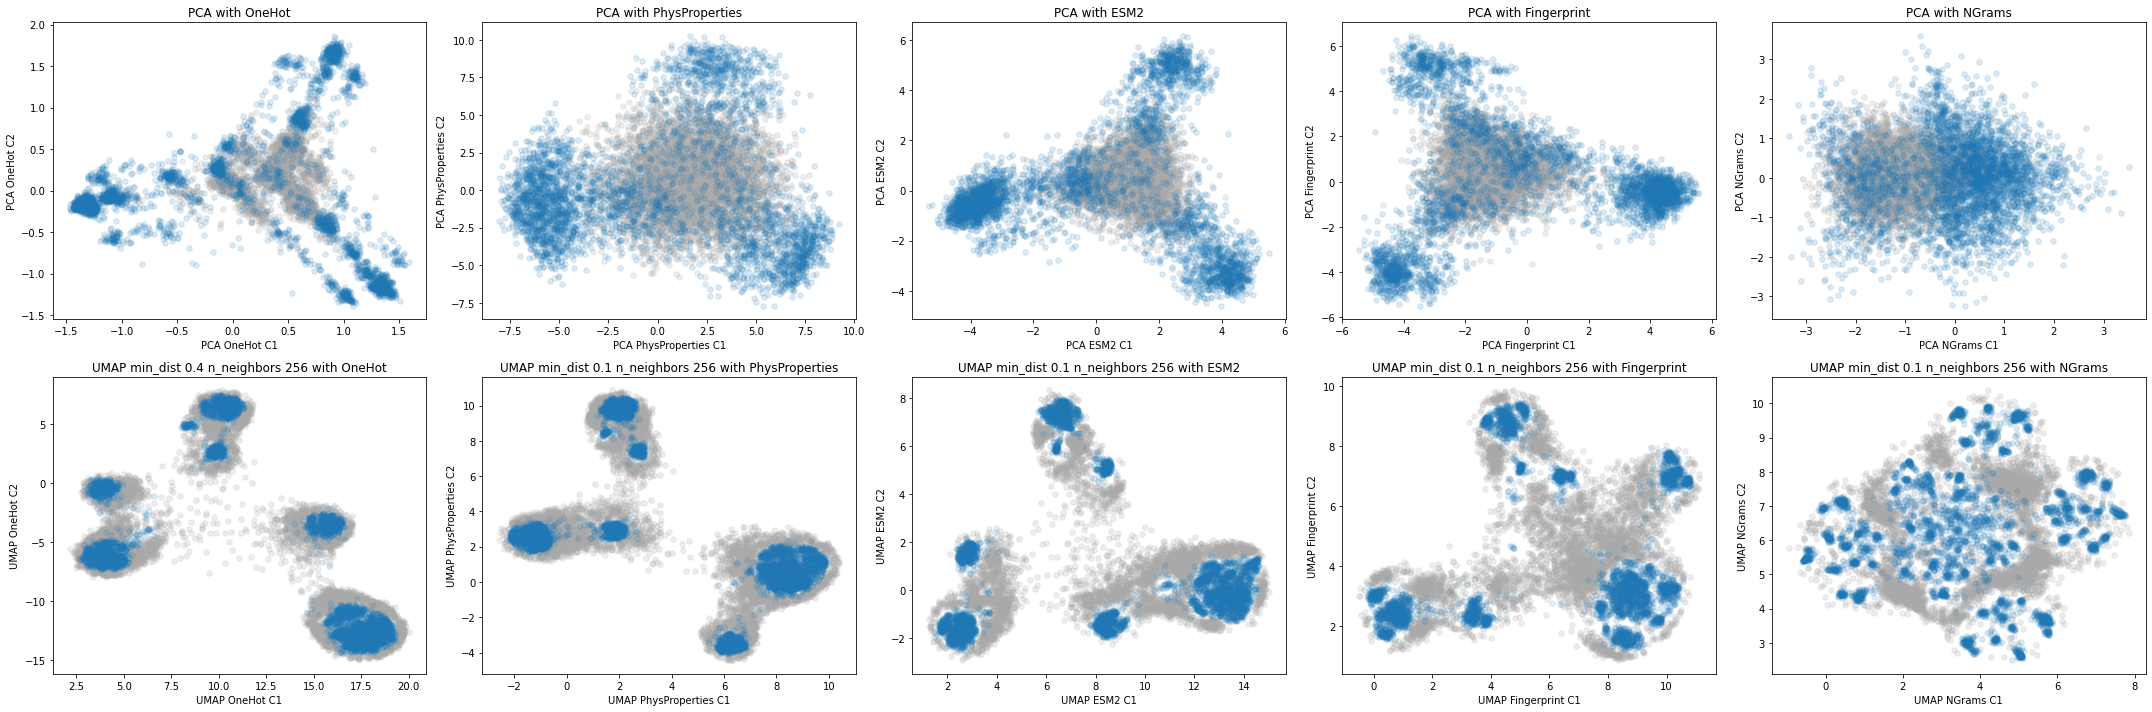

In [51]:
fig, axes = plt.subplots(len(lib_dim_red_list),len(seq_rep_list),figsize = (6*len(seq_rep_list),5*len(lib_dim_red_list)))
lib_reps_plotting = lister(lib_dim_red_list,seq_rep_list)

for ax, (red,enc) in zip(fig.axes,lib_reps_plotting):
    print(f'Plotting {enc} {red}')
    if red == 'UMAP':
        C1 = data[red][min_dict[enc]][enc][2**n_bors[0]][:,0]
        C2 = data[red][min_dict[enc]][enc][2**n_bors[0]][:,1]
        ax.set_title(f'{red} min_dist {min_dict[enc]} n_neighbors {2**n_bors[0]} with {enc}')
    else:
        C1 = data[red][enc][:,0]
        C2 = data[red][enc][:,1]    
        ax.set_title(f'{red} with {enc}')

    LibC1 = lib_data[red][enc][:,0]
    LibC2 = lib_data[red][enc][:,1]
        
    plot = ax.scatter(LibC1,LibC2,s=30,marker='o',alpha=0.2, c='darkgray')
    plot = ax.scatter(C1,C2,s=30,marker='o',alpha=0.15,c='tab:blue') 
    # the AS-MS data is plotted second, and will be on top
    # for more discernment, the libary can be plotted on top

    ax.set_xlabel(f'{red} {enc} C1')
    ax.set_ylabel(f'{red} {enc} C2')

plt.tight_layout()
plt.savefig(f'{Savetitle} ASMS then add LibQC.png',dpi=300)
plt.show